In [7]:
!python --version 

Python 3.12.7


In [ ]:
!pip install opencv-python

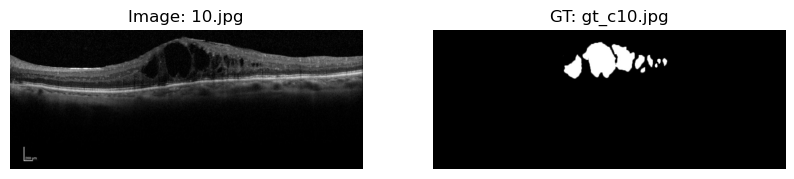

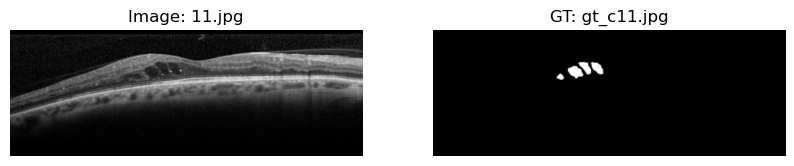

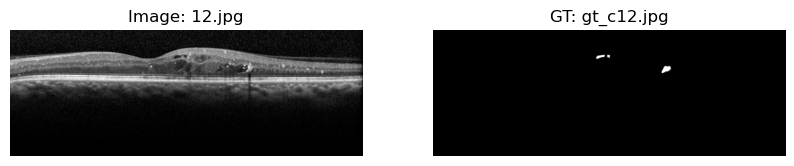

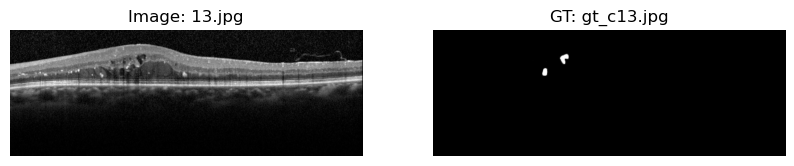

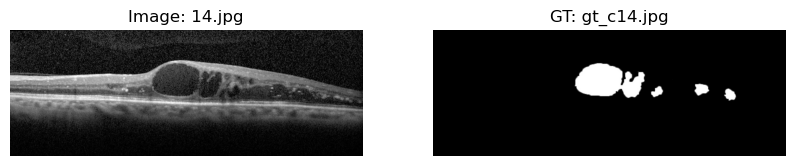

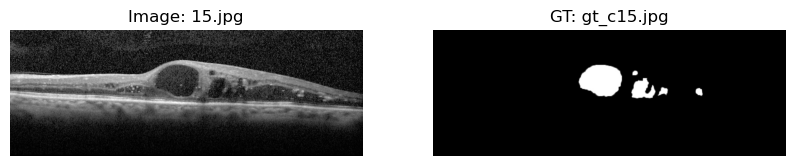

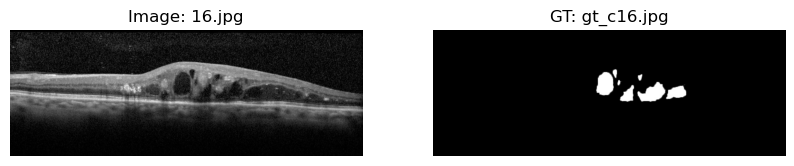

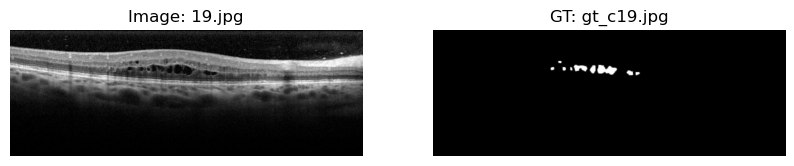

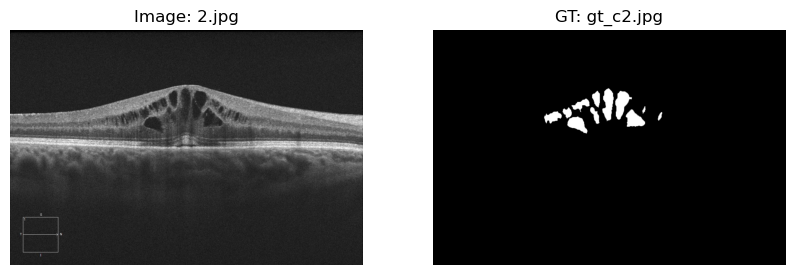

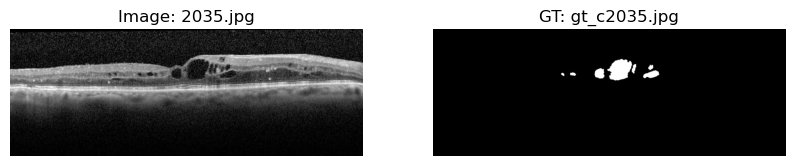

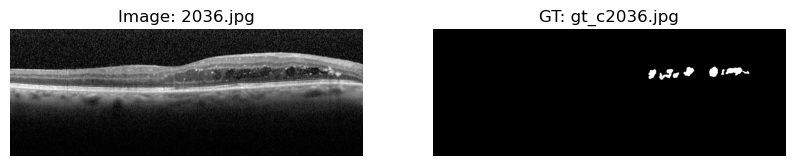

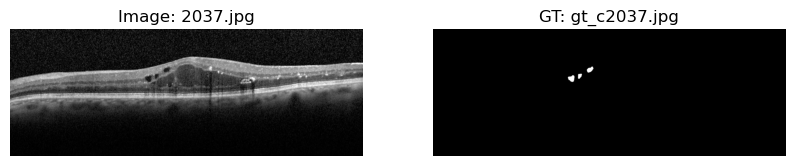

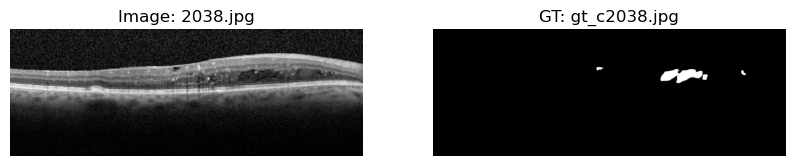

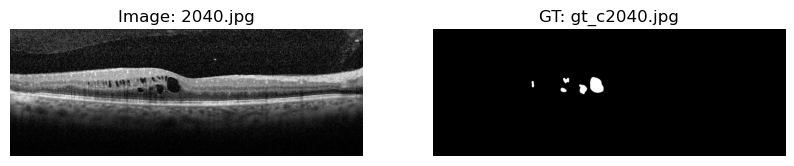

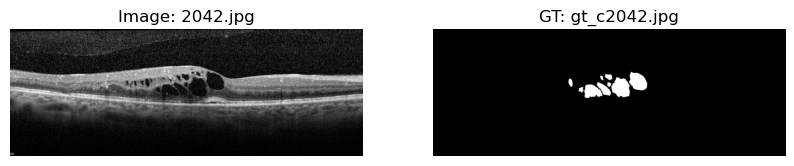

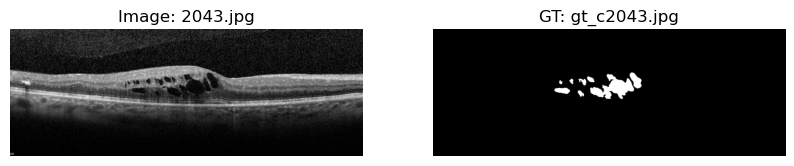

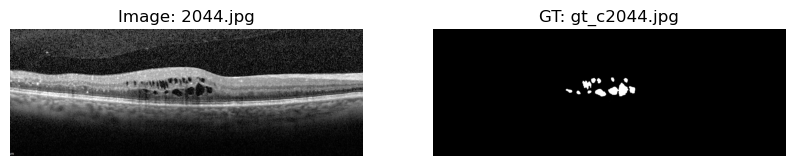

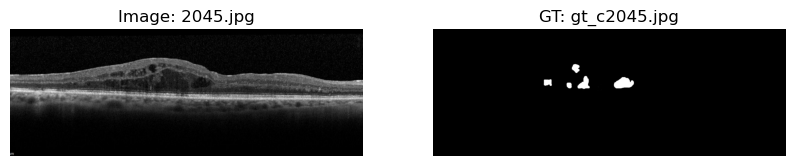

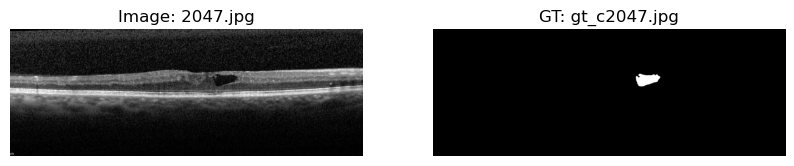

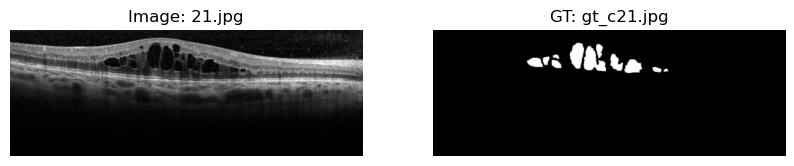

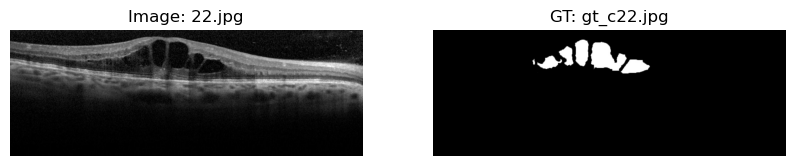

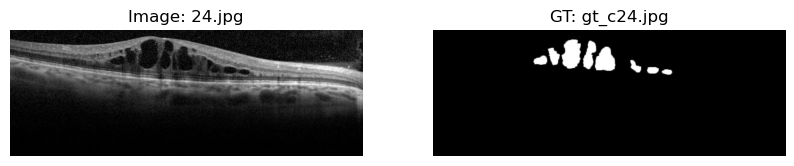

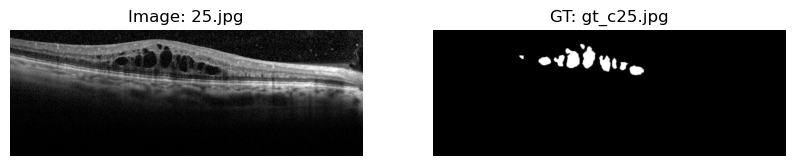

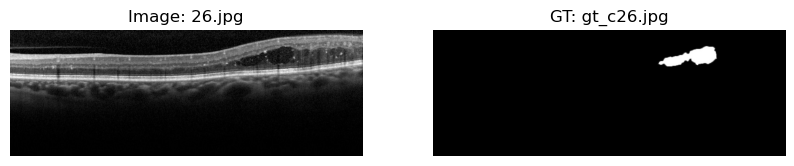

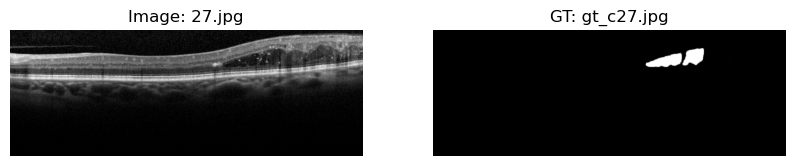

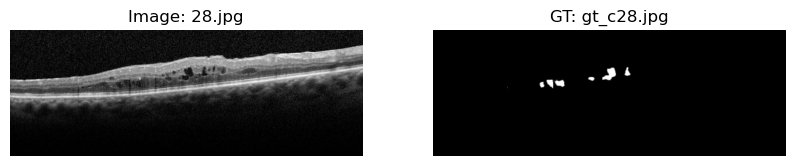

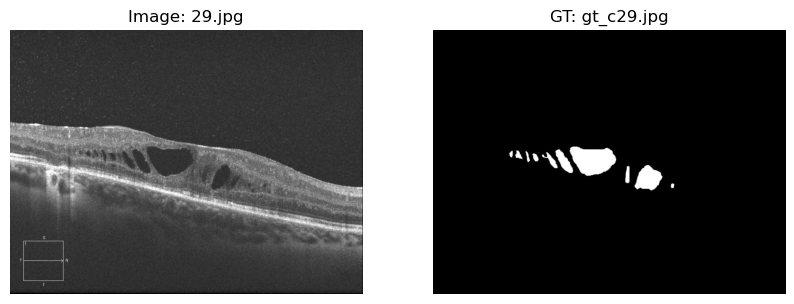

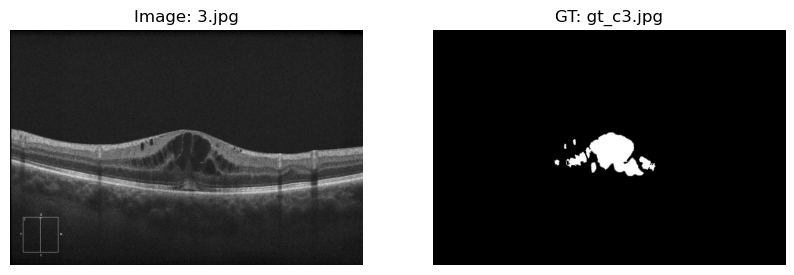

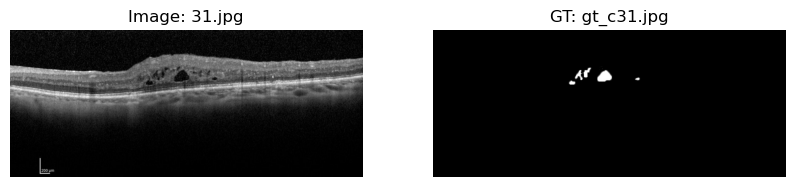

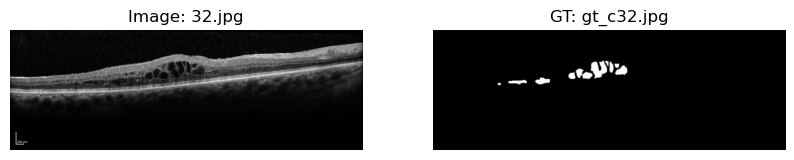

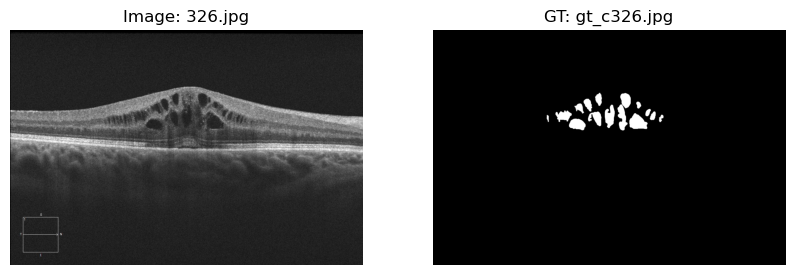

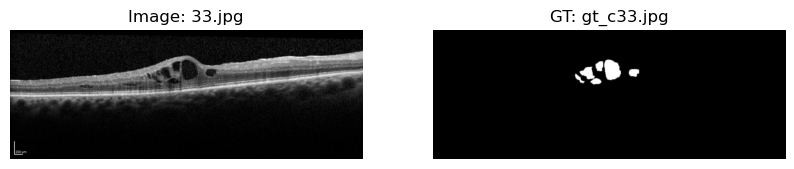

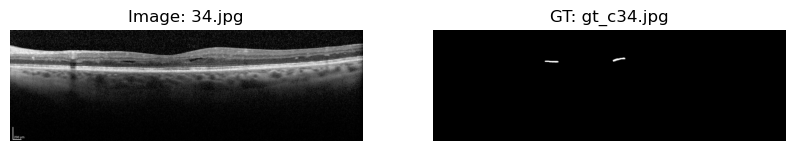

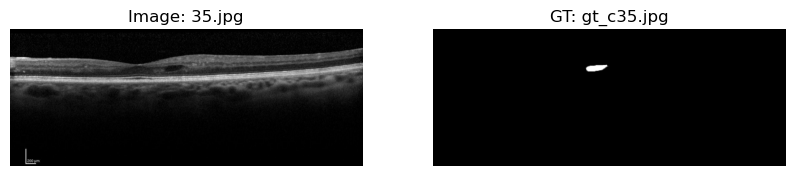

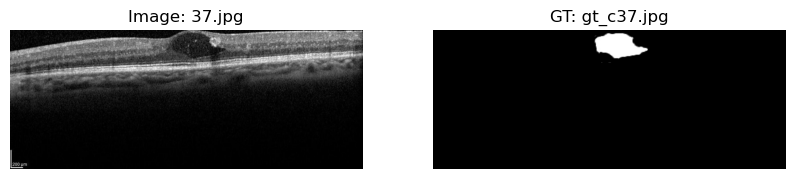

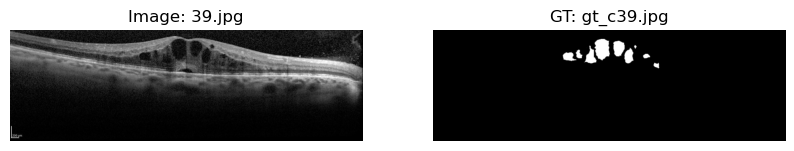

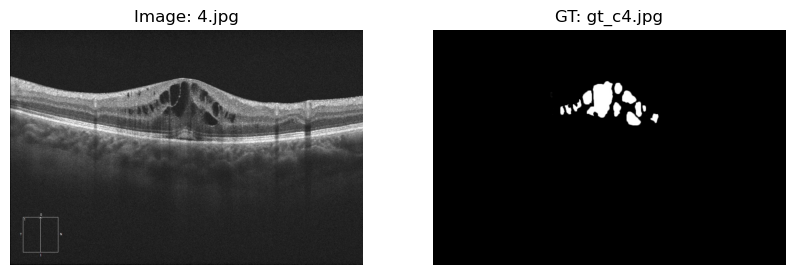

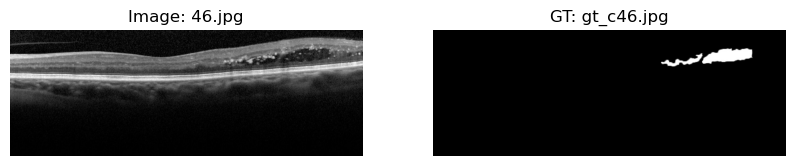

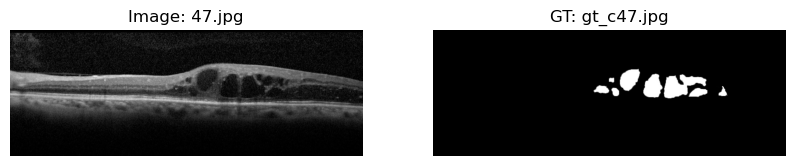

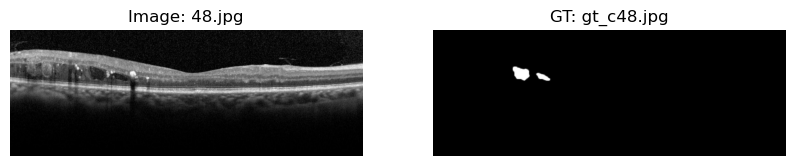

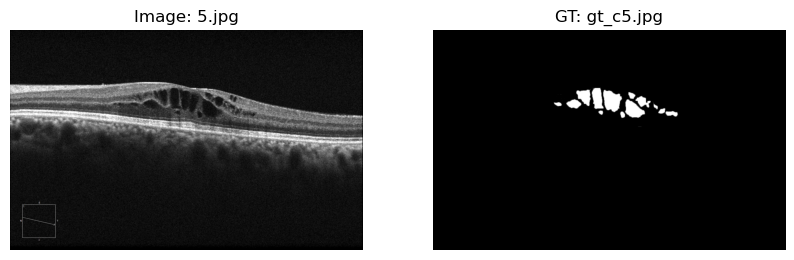

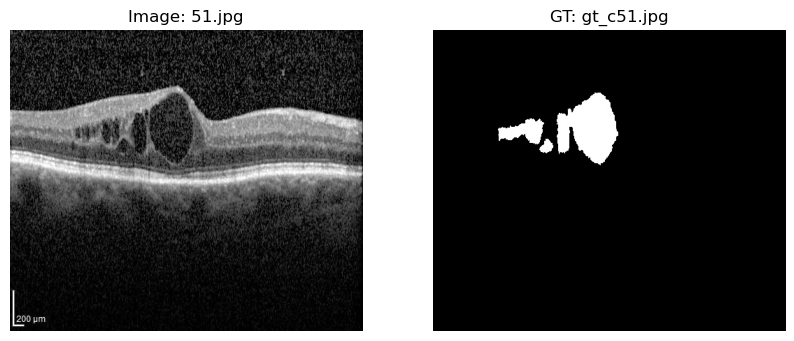

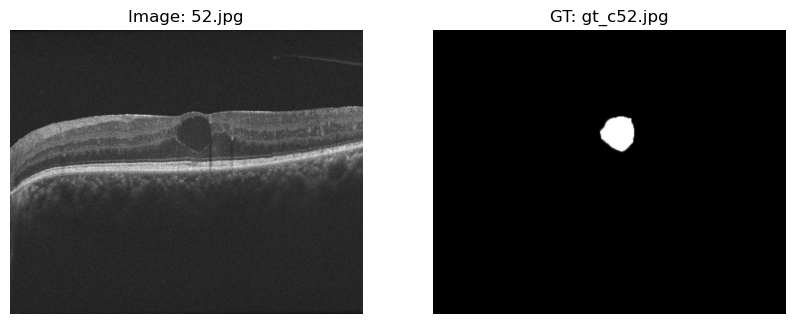

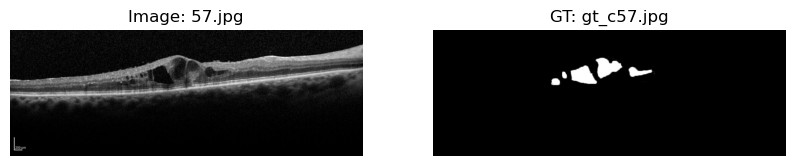

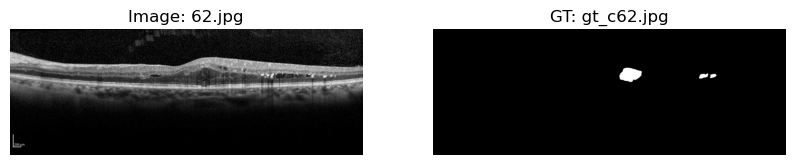

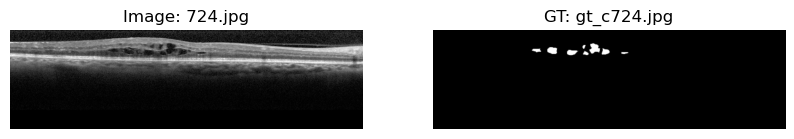

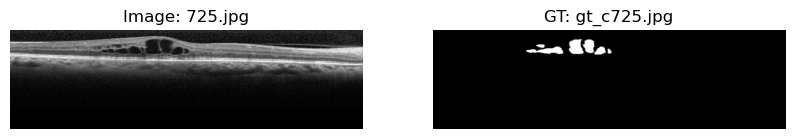

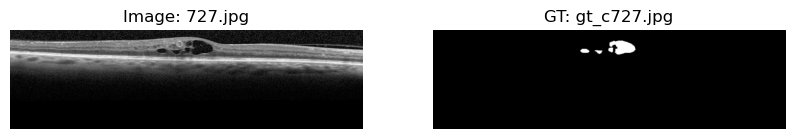

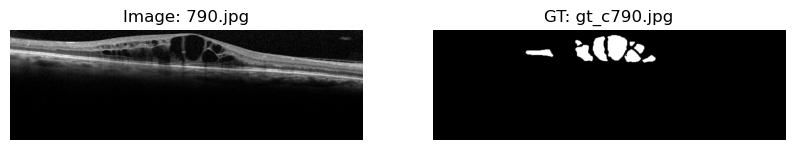

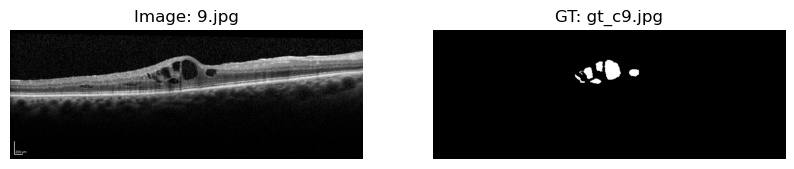

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_display_images(gt_folder, img_folder):
    gt_files = sorted(os.listdir(gt_folder))
    img_files = sorted(os.listdir(img_folder))
    
    for i, (gt_file, img_file) in enumerate(zip(gt_files, img_files)):
        if i >= 50:
            break
        gt_path = os.path.join(gt_folder, gt_file)
        img_path = os.path.join(img_folder, img_file)
        
        gt_image = cv2.imread(gt_path)
        img_image = cv2.imread(img_path)
        
        if gt_image is None or img_image is None:
            print(f"Error loading {gt_file} or {img_file}")
            continue
        
        # Resize images to the same size
        gt_image = cv2.resize(gt_image, (img_image.shape[1], img_image.shape[0]))
        
        # Display images side by side
        plt.figure(figsize=(10,5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Image: {img_file}")
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"GT: {gt_file}")
        
        plt.show()

# Define paths
gt_path = os.path.join("./GT")
img_path = os.path.join("./Images")

# Run the function
load_and_display_images(gt_path, img_path)

In [5]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_paths, gt_paths, transform=None):
        self.image_paths = image_paths
        self.gt_paths = gt_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        gt = cv2.imread(self.gt_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        img = cv2.resize(img, (256, 256))
        gt = cv2.resize(gt, (256, 256))
        
        img = img.astype(np.float32) / 255.0
        gt = (gt > 0).astype(np.float32)  # Ensure binary mask
        
        img = torch.tensor(img).permute(2, 0, 1)  # Convert to (C, H, W) format
        gt = torch.tensor(gt).unsqueeze(0)  # Add channel dimension
        
        return img, gt
    
    @classmethod
    def from_folders(cls, gt_folder, img_folder, transform=None):
        gt_files = sorted(os.listdir(gt_folder))
        img_files = sorted(os.listdir(img_folder))
        
        gt_paths = [os.path.join(gt_folder, f) for f in gt_files]
        img_paths = [os.path.join(img_folder, f) for f in img_files]
        
        return cls(img_paths, gt_paths, transform)

# Define U-Net Model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))
        
        return torch.sigmoid(self.final_conv(dec1))

# 10-Fold Cross Validation Training
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def train_and_validate(model, dataset, criterion, optimizer, device, epochs=10):
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"Fold {fold+1}/10")
        train_sub = Subset(dataset, train_idx)
        val_sub = Subset(dataset, val_idx)
        
        train_loader = DataLoader(train_sub, batch_size=8, shuffle=True)
        val_loader = DataLoader(val_sub, batch_size=8, shuffle=False)
        
        model.to(device)
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for images, masks in train_loader:
                images, masks = images.to(device), masks.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")
            
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    val_loss += loss.item()
            print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss/len(val_loader):.4f}")
        
        torch.save(model.state_dict(), f"unet_model_fold{fold+1}.pth")
        print(f"Model for fold {fold+1} saved.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = CustomDataset.from_folders("./GT", "images")
    model = UNet()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    train_and_validate(model, dataset, criterion, optimizer, device, epochs=10)


Fold 1/10
Epoch 1/10, Train Loss: 0.9432
Epoch 1/10, Val Loss: 0.9438
Epoch 2/10, Train Loss: 0.9361
Epoch 2/10, Val Loss: 0.9341
Epoch 3/10, Train Loss: 0.9226
Epoch 3/10, Val Loss: 0.9121
Epoch 4/10, Train Loss: 0.8772
Epoch 4/10, Val Loss: 0.7669
Epoch 5/10, Train Loss: 0.7087
Epoch 5/10, Val Loss: 0.6931
Epoch 6/10, Train Loss: 0.6931
Epoch 6/10, Val Loss: 0.6931
Epoch 7/10, Train Loss: 0.6931
Epoch 7/10, Val Loss: 0.6931
Epoch 8/10, Train Loss: 0.6931
Epoch 8/10, Val Loss: 0.6931
Epoch 9/10, Train Loss: 0.6931
Epoch 9/10, Val Loss: 0.6931
Epoch 10/10, Train Loss: 0.6931
Epoch 10/10, Val Loss: 0.6931
Model for fold 1 saved.
Fold 2/10
Epoch 1/10, Train Loss: 0.6931
Epoch 1/10, Val Loss: 0.6931
Epoch 2/10, Train Loss: 0.6931
Epoch 2/10, Val Loss: 0.6931
Epoch 3/10, Train Loss: 0.6931
Epoch 3/10, Val Loss: 0.6931
Epoch 4/10, Train Loss: 0.6931
Epoch 4/10, Val Loss: 0.6931
Epoch 5/10, Train Loss: 0.6931
Epoch 5/10, Val Loss: 0.6931
Epoch 6/10, Train Loss: 0.6931
Epoch 6/10, Val Loss: 0